# Tarea: Modelo de regresión logística

### Andrés Nieto Guadarrama

### Base de datos

Carguemos la base de datos:

In [190]:
import pandas as pd
from io import StringIO
import requests
from sklearn.model_selection import train_test_split
columns=["bi_rads", "age", "shape", "margin", "density", "severity"]
datalink = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"
df = pd.read_csv(StringIO(requests.get(datalink).text),
                 header=None, na_values="?")
df.columns = columns

train, test = train_test_split(df, test_size=0.2, random_state=314)
train.head(3)

,bi_rads,age,shape,margin,density,severity
210,4.0,46.0,1.0,1.0,1.0,0
946,4.0,57.0,2.0,4.0,3.0,0
638,4.0,67.0,2.0,1.0,3.0,0


In [191]:
train = train.query("bi_rads != 55")

### Exploración de la base de datos

¿De qué tipo son las variables de la base?

In [192]:
df_xtest = test[["age", "margin", "shape", "density", "bi_rads"]]
print(f"Variables continuas: {df_xtest.dtypes[train.dtypes == np.float64].index}")
print(f"Variables ordinales: {df_xtest.dtypes[train.dtypes == np.int].index}")

Variables continuas: Index(['age', 'margin', 'shape', 'density', 'bi_rads'], dtype='object')
Variables ordinales: Index([], dtype='object')


### Modelo

In [193]:
def resultado_rl(arr):
    '''
    Se crea una función auxiliar para 
    recuperar la predicción de la 
    variable (categórica) del modelo de
    regrsión logística.
    '''
    resp=[]
    for i in range(len(arr)):
        if arr[i][0]>arr[i][1]:
            resp.append(0)
        else:
            resp.append(1)
    return resp

In [195]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

xtrain, ytrain = train[["age", "margin","shape", "bi_rads", "density"]], train[["severity"]]

input_encode = Pipeline([
    ("imputer", SimpleImputer()),
    ("ohe", OneHotEncoder(categories="auto"))
])

cX = ColumnTransformer([
    ("categoricals", input_encode, ["margin", "shape", "bi_rads", "density"]),
    ("continuous", SimpleImputer(), ["age"])
])

logreg = Pipeline([
    ("cX", cX),
    ("model", LogisticRegression(solver="lbfgs", max_iter=500))
])


logreg.fit(xtrain, ytrain)

xtest = test[["age", "margin", "shape", "density", "bi_rads"]].values
ytest = test.severity

cv = cross_validate(logreg, train, train["severity"], cv=10)
print(f"score del modelo por cross-validation: {cv['test_score'].mean():0.3%}")

C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score del modelo por cross-validation: 82.001%


### Graficación

C:\Users\AN012491\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


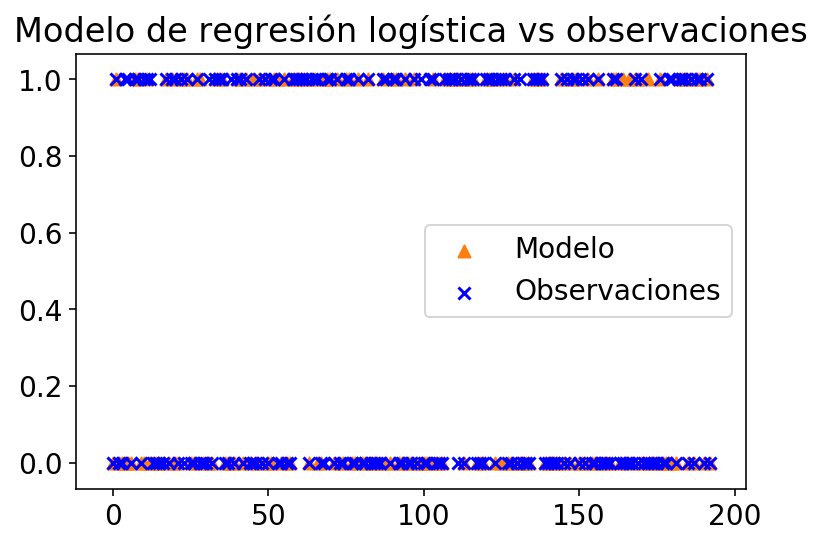

In [196]:
#Resultado del modelo:
      
xrange = np.arange(0,len(ytest))
#ytest.plot(x=xrange, y="severity",kind="scatter",alpha=0.4)
plt.scatter(xrange, resultado_rl(logreg.predict_proba(df_xtest)),color="tab:orange",marker="^",label="Modelo")
plt.scatter(xrange, ytest,color="blue",marker="x",label="Observaciones")
plt.title("Modelo de regresión logística vs observaciones")
plt.legend()
plt.show()

### Matriz de confusión

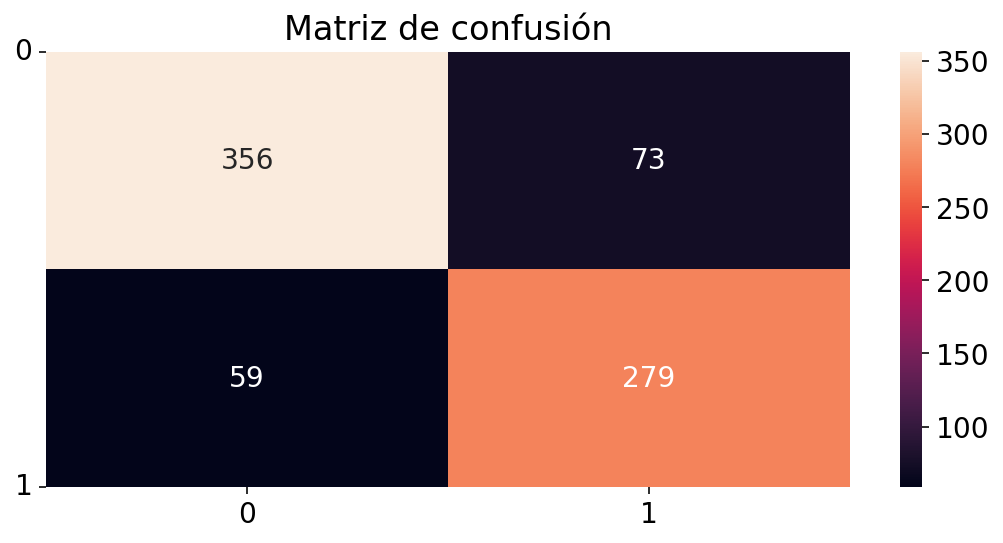

In [197]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14

cmat = confusion_matrix(ytrain, logreg.predict(xtrain))
df_cmat=pd.DataFrame({'0':cmat[0],'1':cmat[1]})

f = plt.figure(figsize=(9,4))
sns.heatmap(df_cmat, annot=True, fmt="d")
plt.title('Matriz de confusión')
plt.yticks([0,2],('0','1'), rotation=0, fontsize="14", va="center")
plt.show()

### Precisión y recall

In [199]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
ypreds = logreg.predict(xtrain)
print(f"Precisión: {precision_score(ytrain, ypreds):0.2%}")
print(f"Recall: {recall_score(ytrain, ypreds):>10.2%}")
print(f"Accuracy: {accuracy_score(ytrain, ypreds):>8.2%}")

Precisión: 82.54%
Recall:     79.26%
Accuracy:   82.79%
